In [1]:
import scanpy as sc
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.interpolate import interp1d
from pathlib import Path

import numpy as np
import pandas as pd
import anndata as ad

import matplotlib.pyplot as plt

import os
import sys
import logging

In [2]:
adata_male = '/ocean/projects/cis240075p/asachan/datasets/TA_muscle/human_SKM_ageing_atlas_2024/human_male_intercostal_myofiber.h5ad'
adata_female = '/ocean/projects/cis240075p/asachan/datasets/TA_muscle/human_SKM_ageing_atlas_2024/human_female_intercostal_myofiber.h5ad'
out_tmp = '/ocean/projects/cis240075p/asachan/datasets/TA_muscle/human_SKM_ageing_atlas_2024/tmp'

In [3]:
adata_male = sc.read_h5ad(adata_male)
adata_female = sc.read_h5ad(adata_female)

In [4]:
adata_male.obs

,SampleID,Age_group,Age_bin,batch,annotation_level0,annotation_level1,annotation_level2,n_counts,n_genes,percent_mito,...,tissue_type,cell_type,assay,disease,organism,sex,tissue,self_reported_ethnicity,development_stage,observation_joinid
5386STDY7600838-AACACGTGTGAAAGAG,5386STDY7600838,60-65,old,cells,MF-Isc(fg),MF-Isc(fg),MF_typeI(fg),32101.0,4032.0,0.000125,...,tissue,type I muscle cell,10x 3' v2,normal,Homo sapiens,male,intercostal muscle,European,seventh decade stage,jjX3?D^C>1
5386STDY7600838-CGCGTTTGTTACCGAT,5386STDY7600838,60-65,old,cells,MF-Isc(fg),MF-Isc(fg),MF_typeI(fg),27748.0,3327.0,0.000000,...,tissue,type I muscle cell,10x 3' v2,normal,Homo sapiens,male,intercostal muscle,European,seventh decade stage,jK2q6dZ0jz
5386STDY7600838-GTCAAGTTCGGCTTGG,5386STDY7600838,60-65,old,cells,MF-Isc(fg),MF-Isc(fg),MF_typeI(fg),26334.0,3913.0,0.000038,...,tissue,type I muscle cell,10x 3' v2,normal,Homo sapiens,male,intercostal muscle,European,seventh decade stage,t2~{Kwt)1L
5386STDY7600838-CTGCGGAGTCACCCAG,5386STDY7600838,60-65,old,cells,MF-Isc(fg),MF-Isc(fg),MF_typeI(fg),22241.0,3402.0,0.000000,...,tissue,type I muscle cell,10x 3' v2,normal,Homo sapiens,male,intercostal muscle,European,seventh decade stage,CLpYF%d<Z>
5386STDY7600838-GACTGCGGTCAAAGAT,5386STDY7600838,60-65,old,cells,MF-Isc(fg),MF-Isc(fg),MF_typeI(fg),19684.0,3441.0,0.000000,...,tissue,type I muscle cell,10x 3' v2,normal,Homo sapiens,male,intercostal muscle,European,seventh decade stage,3%D7j06acM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WS_A_SKM10691778-TCCTTCTCATTCAGCA,WS_A_SKM10691778,25-30,young,nuclei,MuSC,MuSC,MuSC,544.0,419.0,0.000000,...,tissue,skeletal muscle satellite stem cell,10x 3' v3,normal,Homo sapiens,male,intercostal muscle,European,third decade stage,?ac503Bga|
WS_A_SKM10691778-TACAGGTCATCCGATA,WS_A_SKM10691778,25-30,young,nuclei,MuSC,MuSC,MuSC,543.0,433.0,0.001842,...,tissue,skeletal muscle satellite stem cell,10x 3' v3,normal,Homo sapiens,male,intercostal muscle,European,third decade stage,<MQvqRw17m
WS_A_SKM10691778-GGGTAGATCCACGTGG,WS_A_SKM10691778,25-30,young,nuclei,MuSC,MuSC,MuSC,538.0,427.0,0.000000,...,tissue,skeletal muscle satellite stem cell,10x 3' v3,normal,Homo sapiens,male,intercostal muscle,European,third decade stage,v<RDDC4&2b
WS_A_SKM10691778-TCTTCCTCAGTTCTAG,WS_A_SKM10691778,25-30,young,nuclei,MuSC,MuSC,MuSC,524.0,430.0,0.005725,...,tissue,skeletal muscle satellite stem cell,10x 3' v3,normal,Homo sapiens,male,intercostal muscle,European,third decade stage,RQ(iBKemwq


In [5]:
adata_female.obs

,SampleID,Age_group,Age_bin,batch,annotation_level0,annotation_level1,annotation_level2,n_counts,n_genes,percent_mito,...,tissue_type,cell_type,assay,disease,organism,sex,tissue,self_reported_ethnicity,development_stage,observation_joinid
mus_SNuc7468112-GCGAGAACAGTCAGCC,mus_SNuc7468112,70-75,old,cells,MF-Isc(fg),MF-Isc(fg),MF_typeI(fg),33688.0,3905.0,0.000000,...,tissue,type I muscle cell,10x 3' v2,normal,Homo sapiens,female,intercostal muscle,European,eighth decade stage,<)tgYH;ve=
mus_SNuc7468112-CAAGAAATCGGCGCAT,mus_SNuc7468112,70-75,old,cells,MF-Isc(fg),MF-Isc(fg),MF_typeI(fg),22100.0,3000.0,0.000045,...,tissue,type I muscle cell,10x 3' v2,normal,Homo sapiens,female,intercostal muscle,European,eighth decade stage,&alEL(xYeD
mus_SNuc7468112-GCTGCGATCTTGGGTA,mus_SNuc7468112,70-75,old,cells,MF-Isc(fg),MF-Isc(fg),MF_typeI(fg),20320.0,3966.0,0.002756,...,tissue,type I muscle cell,10x 3' v2,normal,Homo sapiens,female,intercostal muscle,European,eighth decade stage,!qwvZcB%2)
mus_SNuc7468112-CTCGGGACAGGTCGTC,mus_SNuc7468112,70-75,old,cells,MF-Isc(fg),MF-Isc(fg),MF_typeI(fg),18099.0,3096.0,0.000442,...,tissue,type I muscle cell,10x 3' v2,normal,Homo sapiens,female,intercostal muscle,European,eighth decade stage,@A+wf<mTrW
mus_SNuc7468112-ACCAGTAAGAATAGGG,mus_SNuc7468112,70-75,old,cells,MF-Isc(fg),MF-Isc(fg),MF_typeI(fg),17243.0,2354.0,0.000000,...,tissue,type I muscle cell,10x 3' v2,normal,Homo sapiens,female,intercostal muscle,European,eighth decade stage,Qbz@v@gr$*
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WS_A_SKM10691779-AGGTTACAGGTACATA,WS_A_SKM10691779,55-60,old,nuclei,MF-I,MF-I,MF-I,567.0,427.0,0.000000,...,tissue,type I muscle cell,10x 3' v3,normal,Homo sapiens,female,intercostal muscle,European,sixth decade stage,ylNFl@(sPi
WS_A_SKM10691779-ACTCCCACAGACAATA,WS_A_SKM10691779,55-60,old,nuclei,MF-I,MF-I,MF-I,563.0,410.0,0.000000,...,tissue,type I muscle cell,10x 3' v3,normal,Homo sapiens,female,intercostal muscle,European,sixth decade stage,Mmg_>JOl1w
WS_A_SKM10691779-CATTCTATCCCTTGGT,WS_A_SKM10691779,55-60,old,nuclei,MF-I,MF-I,MF-I,552.0,418.0,0.000000,...,tissue,type I muscle cell,10x 3' v3,normal,Homo sapiens,female,intercostal muscle,European,sixth decade stage,)FC!#cZEV0
WS_A_SKM10691779-GTTGCGGCACCATTCC,WS_A_SKM10691779,55-60,old,nuclei,MF-I,MF-I,MF-I,531.0,407.0,0.000000,...,tissue,type I muscle cell,10x 3' v3,normal,Homo sapiens,female,intercostal muscle,European,sixth decade stage,`G+Z#EFNNU


/ocean/projects/cis240075p/asachan/.conda/envs/scvelo/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


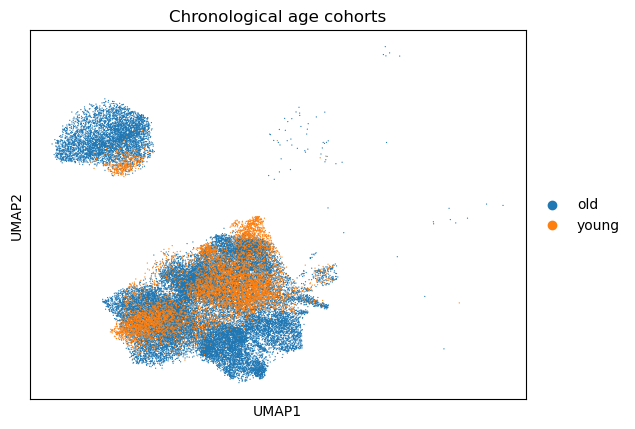

In [6]:
sc.pl.umap(adata_female, color=['Age_bin'], title='Chronological age cohorts')